# VAD (Voice Activity Detection) in Python-Part 3

## 6. More Detailed Explanation of VAD Example at Kaggle
This notebook overviews [Voice activity detection example](https://www.kaggle.com/holzner/voice-activity-detection-example). The VAD example didn't run at first, but the errors were fixed in this notebook. This notebook explains the code without class and the same code converted to class is in [webrt_vad.py](../src/webrt_vad.py). Both codes run just fine.

The following line packing the sample values into binary data is explained further at [struct.pack(...) the pack function in the struct module](https://blog.naver.com/aimldl/221670484768)
```python
raw_samples = struct.pack("%dh" % len(samples), *samples)
```

### 6.1. Overview of the Code
This section shows an improved version of the VAD example code in the previous sub-section. The following Python codes:
* read in a .wav file './english-0.wav',
* show the waveform with and without (peak) normalization,
* partition the frames and feed them into the vad.is_speech function which returns True for speech or False for non-speech frame,
* plot the input waveform and mark speech or non-speech frames (in orange color) on the figure,
* extract the speech parts from the input waveform and save them to variable speech_samples, and finally
* play the speech_samples to verify the extracted part.

### 6.2. Implementation

In [3]:
'''
Prerequisite:
+ Install webrtcvad
  $ pip install webrtcvad
+ Install other packages such as numpy, matplotlib, and scipy
'''
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import wavfile
import webrtcvad
import struct
import IPython.display as ipd

# Read in a .wav file
sample_rate, samples = wavfile.read( '../audio_files/english-0.wav' )
ymax = max( samples )

# Listen to the audio file
ipd.Audio(samples, rate=sample_rate)

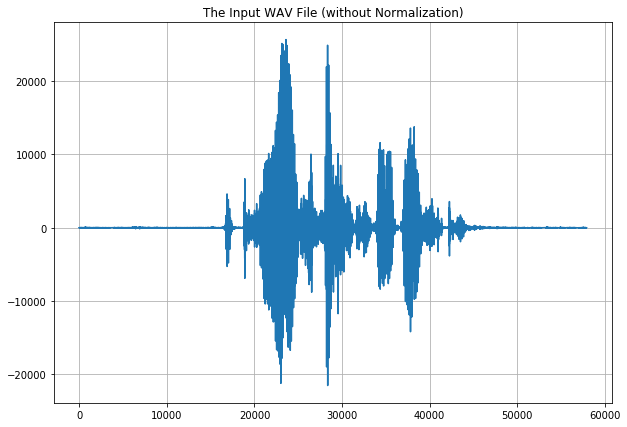

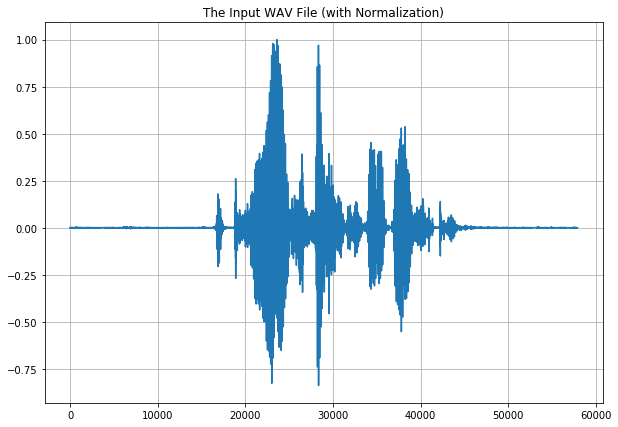

In [4]:
# Plot the input wav file
plt.figure(figsize = (10,7))
plt.plot(samples)
plt.title( 'The Input WAV File (without Normalization)' )
plt.grid()

plt.figure(figsize = (10,7))
plt.plot(samples/ymax)
plt.title( 'The Input WAV File (with Normalization)' )
plt.grid()

samples_per_window = 480
samples = [-10  -5  13  -2 -12 -12   8  -1 -10   1]
raw_samples = b'\xf6\xff\xfb\xff\r\x00\xfe\xff\xf4\xff'


Text(0.5, 1.0, 'The first frame (with normalization)')

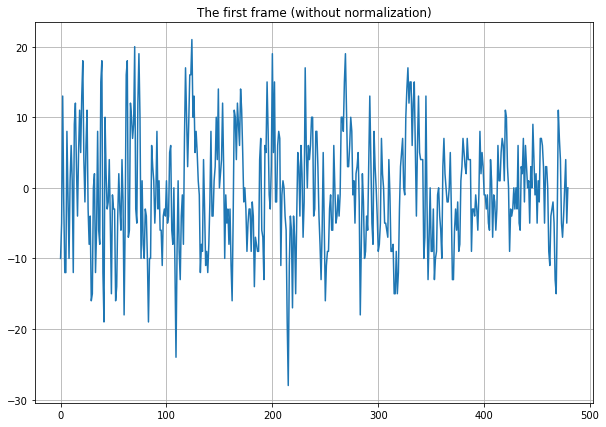

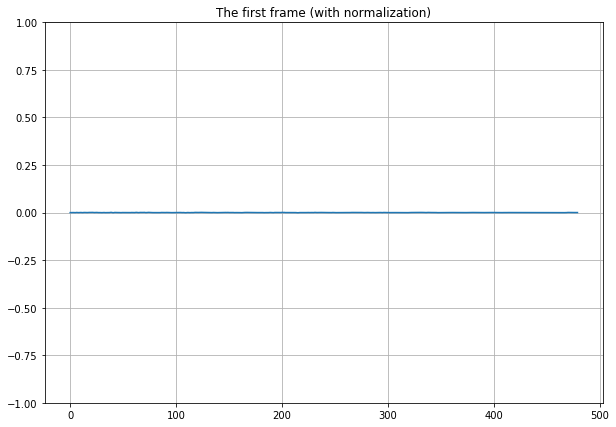

In [5]:
window_duration = 0.03 # duration in seconds
samples_per_window = int(window_duration * sample_rate + 0.5)
bytes_per_sample = 2

print(f'samples_per_window = {samples_per_window}' )
print(f'samples = {samples[:10]}' )  # Print the first 10 samples
raw_samples = struct.pack("%dh" % len(samples), *samples)
print(f'raw_samples = {raw_samples[:10]}' )  # Print the first 10 raw_samples

plt.figure(figsize = (10,7))
plt.plot(samples[:samples_per_window])
plt.grid()
plt.title( 'The first frame (without normalization)' )

plt.figure(figsize = (10,7))
plt.plot( samples[:samples_per_window] / ymax )
plt.grid()
plt.ylim( -1, 1 )
plt.title( 'The first frame (with normalization)' )

In [6]:
vad = webrtcvad.Vad()
vad.set_mode(3)

# segments is a dictionary of {start, stop, is_speech}.
segments = []
for start in np.arange(0, len(samples), samples_per_window):
    stop = min(start + samples_per_window, len(samples))
    this_frame = raw_samples[start * bytes_per_sample: stop * bytes_per_sample]
    is_speech  = vad.is_speech(this_frame, sample_rate = sample_rate)
    segments.append( dict( start = start, stop = stop, is_speech = is_speech) )

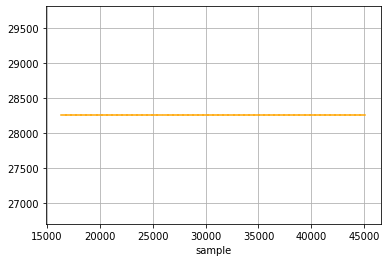

In [7]:
# plot segment identifed as speech
for segment in segments:
    if segment['is_speech']:
        x = [ segment['start'], segment['stop'] - 1]
        y = [ymax * 1.1, ymax * 1.1]  # y = [ 1, 1 ], change like this o normalize the signal
        plt.plot(x, y, color = 'orange')
plt.xlabel('sample')
plt.grid()

The following figure represents VAD with the orange lines. y=0.5 is False, and y=1.0 is True. The waveform in blue is the input .wav file.

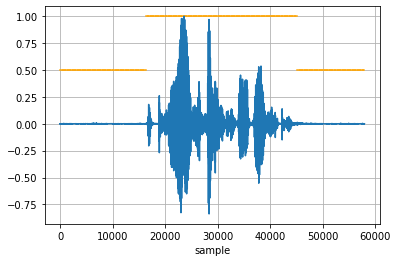

In [8]:
# plot segment identifed as speech
for segment in segments:
    x = [ segment['start'], segment['stop'] - 1]
    if segment['is_speech']:
        y = [1, 1]
    else:
        y = [0.5, 0.5]
    plt.plot(x, y, color = 'orange')
plt.xlabel('sample')
plt.grid()

plt.plot( samples / ymax )

Text(0.5, 1.0, 'Only the Speech Part is Extracted from VAD')

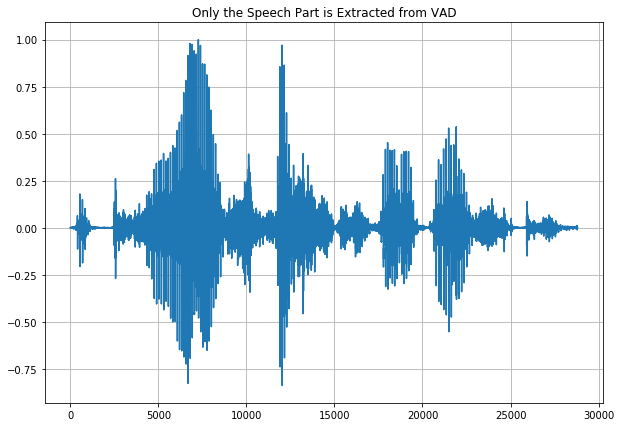

In [9]:
# Get the samples from segment['start'] to segment['stop'] if segment['is_speech']
samples_is_speech = [ samples[segment['start']:segment['stop']] for segment in segments if segment['is_speech']]
speech_samples = np.concatenate( samples_is_speech )

plt.figure(figsize = (10,7))
plt.plot( speech_samples / ymax)
plt.grid()
plt.title( 'Only the Speech Part is Extracted from VAD' )

In [10]:
import IPython.display as ipd
ipd.Audio(speech_samples, rate=sample_rate)

Notice samples is about 3 second long while speech_samples is 1 second long.

TODO: Save the speech_samples

### 6.3. Parameter vad.set_mode: 0~3
In this section, let's check the effect of set_mode which takes in values from 0 to 3. Two functions are defined to improve the readability. In the following figures, check the orange lines with the change of set_mode from 0 to 3.

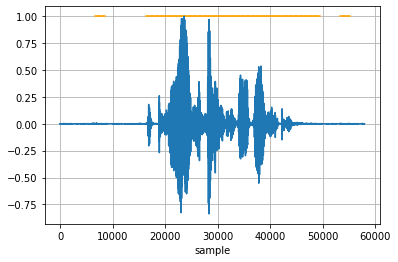

In [12]:
def get_segments( samples, sample_rate, samples_per_window ):
    # segments is a dictionary of {start, stop, is_speech}.
    segments_dicts = []
    len_samples = len(samples)
    
    for start in np.arange(0, len_samples, samples_per_window):
        stop  = min( start + samples_per_window, len_samples )  # For the last frame
        from_ = start * bytes_per_sample
        to    = stop * bytes_per_sample
        this_frame = raw_samples[ from_:to ]
        is_speech  = vad.is_speech( this_frame, sample_rate=sample_rate )
        segments_dicts.append( dict( start=start, stop=stop, is_speech=is_speech) )
    return segments_dicts

def plot_segments( segments, samples, ymax ):
    # plot segment identifed as speech
    for segment in segments:
        if segment['is_speech']:
            x = [ segment['start'], segment['stop'] - 1]
            y = [ 1, 1 ]
            plt.plot(x, y, color = 'orange')
    plt.xlabel( 'sample' )
    plt.grid()
    plt.plot( samples / ymax )

'''
# TODO
def
    # Get the samples from segment['start'] to segment['stop'] if segment['is_speech']
    samples_is_speech = [ samples[segment['start']:segment['stop']] for segment in segments if segment['is_speech']]
    speech_samples = np.concatenate( samples_is_speech )
    
    plt.figure(figsize = (10,7))
    plt.plot( speech_samples / ymax)
    plt.grid()
    plt.title( 'Only the Speech Part is Extracted from VAD' )
# TODO
'''

#vad = webrtcvad.Vad()
vad.set_mode(0)
segments_0 = get_segments( samples, sample_rate, samples_per_window )
plot_segments( segments_0, samples, ymax )

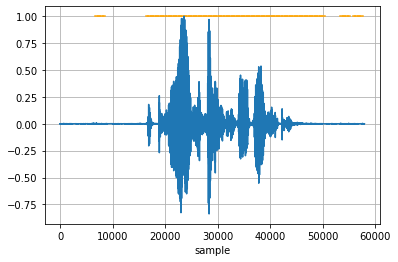

In [13]:
vad.set_mode(1)
segments_1 = get_segments( samples, sample_rate, samples_per_window )
plot_segments( segments_1, samples, ymax )

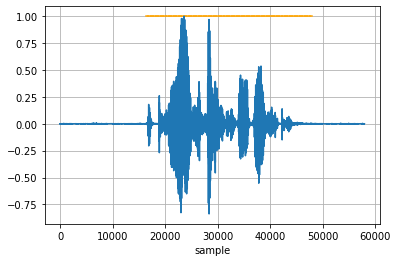

In [14]:
vad.set_mode(2)
segments_2 = get_segments( samples, sample_rate, samples_per_window )
plot_segments( segments_2, samples, ymax )

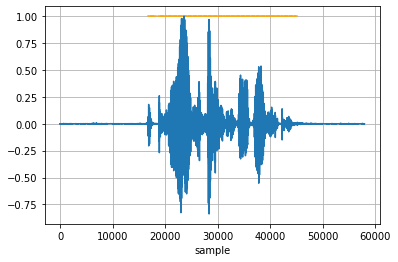

In [15]:
vad.set_mode(3)
segments_3 = get_segments( samples, sample_rate, samples_per_window )
plot_segments( segments_3, samples, ymax )

## 6.4. Window or Frame?
The terminology window was used to be consistent with the example code. However frame is a more accurate term as an error message suggests.

```python
# is_speech    = vad.is_speech( this_window, sample_rate=fs )
Error: Error while processing frame
```

### 6.5. WebRT VAD in Class [webrt_vad.py](../src/webrt_vad.py)
The above code is converted to class in [webrt_vad.py](../src/webrt_vad.py) for code reuse. To get the same results above, copy [webrt_vad.py](../src/webrt_vad.py) to a sub-directory vad and run function test_run() as follows:

```python
vad = WebRtVad()
vad.test_run()
```

An example to import this class is below.
```python
from vad.webrt_vad import WebRtVad

vad = WebRtVad()
vad.test_run()
```

(EOF)